# Arbol de decision

In [1]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

import graphviz

In [2]:
from preprocessing import prepararSetDeDatos
from preprocessing import arbolDeDecisionPreprocessing

In [3]:
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')

In [4]:
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')

Llamar a preprocessing para el arbol

In [5]:
X,y = prepararSetDeDatos(X,y)
X = arbolDeDecisionPreprocessing(X) #crear prepocessing

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Árboles de decisión

In [7]:
def construir_arbol(X_train, y_train, profundidad_maxima, criterio):
    arbol_clasificador = tree.DecisionTreeClassifier(random_state=117, max_depth=profundidad_maxima, criterion = criterio)
    arbol_clasificador.fit(X_train, y_train)    
    return arbol_clasificador

In [8]:
def predecir(X_test, arbol_clasificador):
    y_pred = arbol_clasificador.predict(X_test)
    return y_pred

In [9]:
def accuracy(y_pred, y_test):
    accuracy_ = pd.Series(np.array(y_test["volveria"]) == y_pred).mean()
    return accuracy_

In [10]:
def graficar_arbol(arbol_clasificador, profundidad_maxima):
    dot_data = tree.export_graphviz(arbol_clasificador, feature_names=X.columns.to_list(),  max_depth = profundidad_maxima) 
    graph = graphviz.Source(dot_data) 
    graph.render("arbol de decision")

In [11]:
def obtener_accuracies_segun_profundidad(profundidades, criterio):
    accuracies = []
    profundidades_maximas = []

    for profundidad_maxima in profundidades:
        arbol_clasificador = construir_arbol(X_train, y_train, profundidad_maxima, criterio)
        y_pred = predecir(X_test, arbol_clasificador)
        accuracy_ = accuracy(y_pred, y_test)

        accuracies.append(accuracy_)
        profundidades_maximas.append(profundidad_maxima)
        
    return accuracies, profundidades_maximas

In [12]:
def graficar_accuracy_vs_profundidad(accuracy, profundidades):
    plt.subplots(dpi = 120)
    plt.plot(profundidades, accuracies, color='lightblue', linestyle='dashed', linewidth = 2, 
             marker='o', markerfacecolor='blue', markersize=7) 
    plt.xlabel('Profundidad del arbol')
    plt.ylabel('Accuracy sobre train')
    plt.title("Accuracy segun profundidad")

    axes = plt.gca()
    axes.set_ylim([0,1])

### Accuracy segun profundidad

Lo primero que haremos es construir y entrenar 10 árboles con el criterio de impureza de Gini de profundidades 1 a 10 y luego otros 10 árboles con el criterio de ganancia de información.

Para cada uno de estos árboles calculamos el accuracy y vemos en que profundidad se alcanzó el máximo accuracy.

In [13]:
accuracies, profundidades = obtener_accuracies_segun_profundidad([1,2,3,4,5,6,7,8,9,10], "gini")

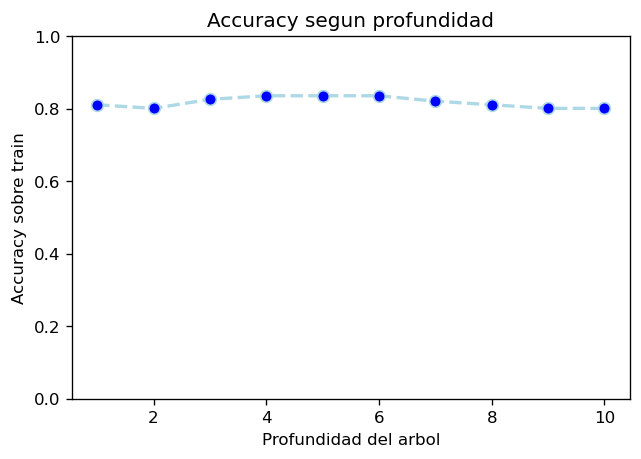

In [14]:
graficar_accuracy_vs_profundidad(accuracies, profundidades)

In [15]:
accuracies, profundidades = obtener_accuracies_segun_profundidad([1,2,3,4,5,6,7,8,9,10], "entropy")

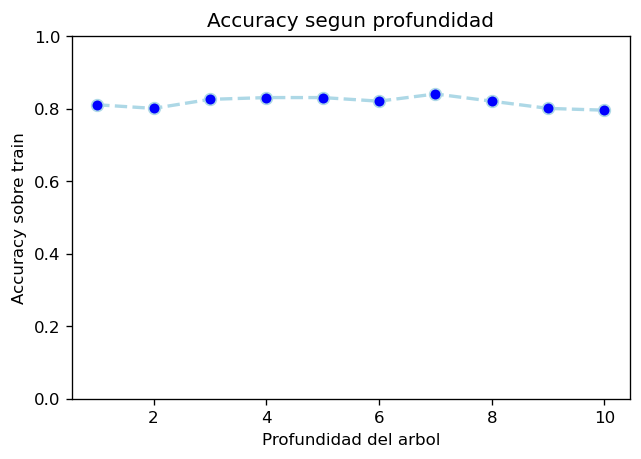

In [16]:
graficar_accuracy_vs_profundidad(accuracies, profundidades)

Observamos que en ambos casos el máximo accuracy se alcanzó para la profundidad 4 y por eso utilizaremos esta profundidad para estudiar las matrices de confusión

In [17]:
arbol_clasificador = construir_arbol(X_train, y_train, 4, "gini")
y_pred = predecir(X_test, arbol_clasificador)

In [18]:
arbol_clasificador_ganancia_informacion = construir_arbol(X_train, y_train, 4, "entropy")
y_pred_ganancia_informacion = predecir(X_test, arbol_clasificador_ganancia_informacion)

# Matriz de confusión árbol de decisión criterio de impureza de Gini

Text(69.58333333333333, 0.5, 'Real')

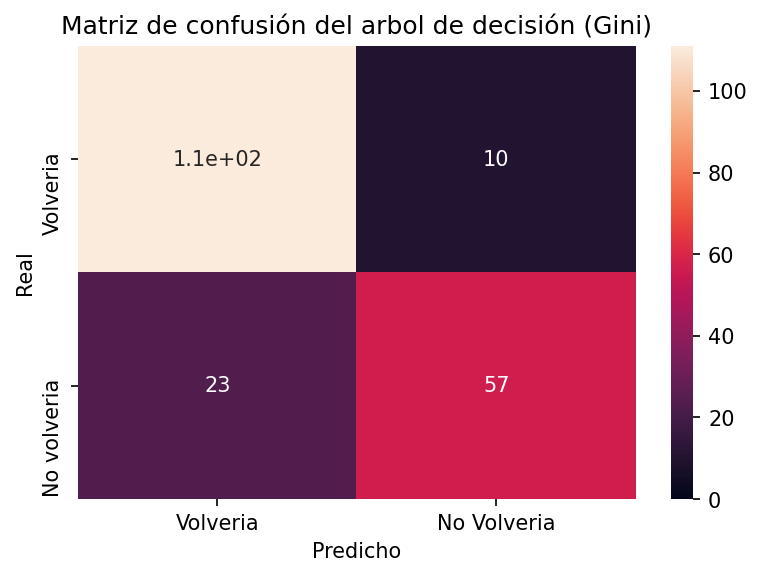

In [19]:
fig, ax = plt.subplots(dpi =150)   
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, vmin = 0, yticklabels=["Volveria","No volveria"], xticklabels=["Volveria", "No Volveria"], ax=ax)
ax.set_title("Matriz de confusión del arbol de decisión (Gini)")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")

Text(69.58333333333333, 0.5, 'Real')

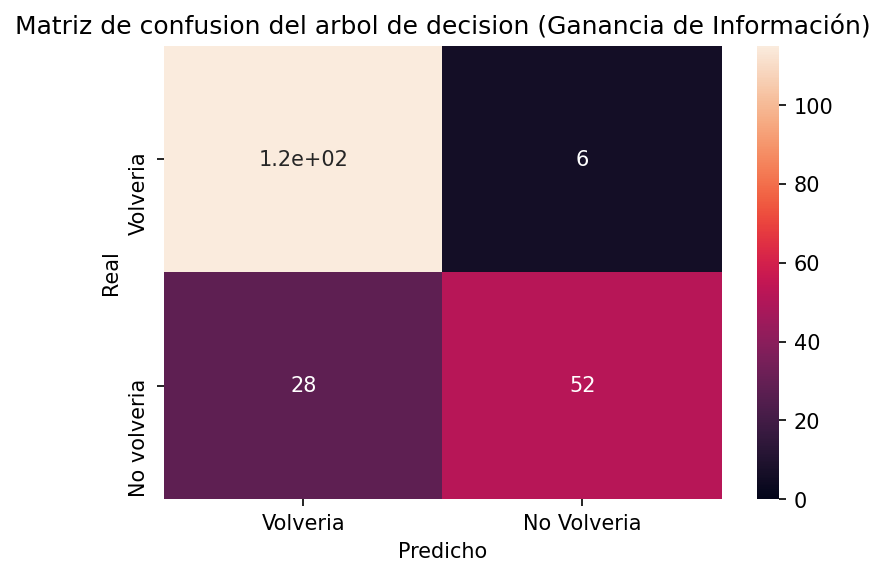

In [20]:
fig, ax = plt.subplots(dpi =150)   
sns.heatmap(confusion_matrix(y_test, y_pred_ganancia_informacion), annot = True, vmin = 0, yticklabels=["Volveria","No volveria"], xticklabels=["Volveria", "No Volveria"], ax=ax)
ax.set_title("Matriz de confusion del arbol de decision (Ganancia de Información)")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")

Podemos ver que para la mejor profundidad, el árbol conseguido por el criterio de gini es mejor. Por lo tanto estudiaremos las metricas AUC-ROC para este árbol.

# Metricas

In [21]:
print(classification_report(y_pred, y_test, target_names=["Volveria", "No Voleria"]))

              precision    recall  f1-score   support

    Volveria       0.92      0.83      0.87       134
  No Voleria       0.71      0.85      0.78        67

    accuracy                           0.84       201
   macro avg       0.81      0.84      0.82       201
weighted avg       0.85      0.84      0.84       201



In [22]:
def graficarAUCROC(X_test, X_train, y_test, y_train):

    fpr_cnb_test,tpr_cnb_test,thresholds_cnb_test = roc_curve(y_test, arbol_clasificador.predict_proba(X_test)[:,1])
    fpr_cnb_train,tpr_cnb_train,thresholds_cnb_train = roc_curve(y_train, arbol_clasificador.predict_proba(X_train)[:,1])

    zero_test = np.argmin(np.abs(thresholds_cnb_test))
    zero_train = np.argmin(np.abs(thresholds_cnb_train))

    plt.plot(fpr_cnb_train,tpr_cnb_train,label="ROC Curve Decision Tree Classifier Train")
    plt.plot(fpr_cnb_test,tpr_cnb_test,label="ROC Curve Decision Tree Classifier Test")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr_cnb_test[zero_test],tpr_cnb_test[zero_test],'o',markersize=10,label="threshold zero test",fillstyle="none",c="k",mew=2)
    plt.plot(fpr_cnb_train[zero_train],tpr_cnb_train[zero_train],'x',markersize=10,label="threshold zero train",fillstyle="none",c="k",mew=2)

    plt.legend(loc=4)

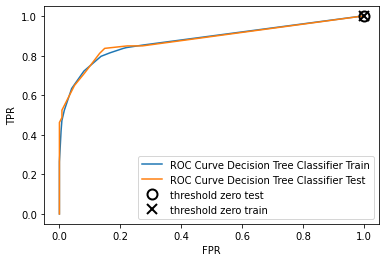

In [23]:
graficarAUCROC(X_test, X_train, y_test, y_train)

In [26]:
auc_rt = roc_auc_score(y_test,arbol_clasificador.predict_proba(X_test)[:, 1])
print("AUC para arbol de decision: {:.3f}".format(auc_rt))

AUC para arbol de decision: 0.880
